# Shallow networks with Keras on CIFAR10

Modify the example given in the class on the MNIST dataset to train and evaluate a shallow
networks on the CIFAR10 dataset.

## Loading the packages

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix

%matplotlib inline

# fix random seed for reproducibility
np.random.seed(42)

# GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Loading the raw data

170500096/170498071 [==============================] - 12s 0us/step


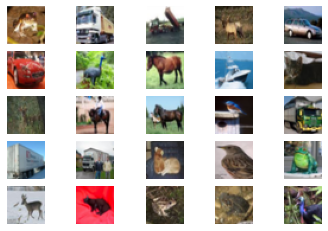

In [3]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,5):
        for j in range(0,5):
            plt.subplot2grid((5,5),(i,j))
            plt.imshow(X[k], cmap='gray')
            k = k+1
            plt.axis('off')
    # show the plot
    plt.show()
    
# Load data & split data between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

show_imgs(X_train)

In [4]:
print(X_train.shape)
print(X_train.dtype)
print(y_train.shape)

(50000, 32, 32, 3)
uint8
(50000, 1)


In [5]:
# Normalize input
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

n_classes = 10
# Conversion to class vectors
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)

50000 train samples
10000 test samples


## One-layer network and weight visualisation
### Define the network

In [15]:
E = 5                # number of epochs
B = 128              # batch size
D = X_train.shape[1:] # dimension of input sample - 784 for MNIST

regularizer = tf.keras.regularizers.l2(0.01)

model = Sequential()
model.add(Flatten(input_shape=D))
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=regularizer))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


### Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/5
391/391 [==============================] - 2s 4ms/step - loss: 2.2530 - accuracy: 0.2669 - val_loss: 1.9858 - val_accuracy: 0.3473
Epoch 2/5
391/391 [==============================] - 1s 3ms/step - loss: 1.9583 - accuracy: 0.3561 - val_loss: 1.9770 - val_accuracy: 0.3235
Epoch 3/5
391/391 [==============================] - 1s 3ms/step - loss: 1.9145 - accuracy: 0.3635 - val_loss: 1.9112 - val_accuracy: 0.3589
Epoch 4/5
391/391 [==============================] - 1s 3ms/step - loss: 1.8861 - accuracy: 0.3658 - val_loss: 1.9133 - val_accuracy: 0.3378
Epoch 5/5
391/391 [==============================] - 1s 3ms/step - loss: 1.8714 - accuracy: 0.3719 - val_loss: 1.8828 - val_accuracy: 0.3689


### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

(3072, 10)
(10,)


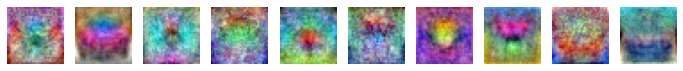

In [21]:
weights = model.get_weights()
for w in weights:
    print(w.shape)
w1 = weights[0]
f = plt.figure(figsize=(12, 12))
for i in range(10):
    ax = f.add_subplot(1, 10, 1+i)
    im = w1[:,i]
    im = im.reshape(32, 32, 3)
    # now put back the pixel values to 0-256 doing a min-max norm and multiplying by 256
    min = np.min(im, axis=0).min(axis=0)
    max = np.max(im, axis=0).max(axis=0)
    im = np.round((im - min)/(max - min) * 255).astype('uint8')
    ax.axis('off')
    ax.imshow(im)

## Two-layers network

### Define the network

In [9]:
E = 30
B = 128
D = X_train.shape[1:]

def create_model(n_neurons:int=128):
    model = Sequential()
    model.add(Flatten(input_shape=D))
    model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


### Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [10]:
log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
                verbose=1, validation_data=(X_test, Y_test))

Epoch 1/30
391/391 [==============================] - 2s 4ms/step - loss: 2.0511 - accuracy: 0.2691 - val_loss: 1.8077 - val_accuracy: 0.3750
Epoch 2/30
391/391 [==============================] - 2s 4ms/step - loss: 1.7882 - accuracy: 0.3656 - val_loss: 1.7549 - val_accuracy: 0.3827
Epoch 3/30
391/391 [==============================] - 2s 4ms/step - loss: 1.7122 - accuracy: 0.3934 - val_loss: 1.6832 - val_accuracy: 0.4066
Epoch 4/30
391/391 [==============================] - 2s 4ms/step - loss: 1.6624 - accuracy: 0.4137 - val_loss: 1.6551 - val_accuracy: 0.4142
Epoch 5/30
391/391 [==============================] - 1s 4ms/step - loss: 1.6322 - accuracy: 0.4193 - val_loss: 1.6317 - val_accuracy: 0.4225
Epoch 6/30
391/391 [==============================] - 1s 4ms/step - loss: 1.6083 - accuracy: 0.4296 - val_loss: 1.6230 - val_accuracy: 0.4262
Epoch 7/30
391/391 [==============================] - 1s 4ms/step - loss: 1.5929 - accuracy: 0.4366 - val_loss: 1.6056 - val_accuracy: 0.4353
Epoch 

## Evaluate the network

### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

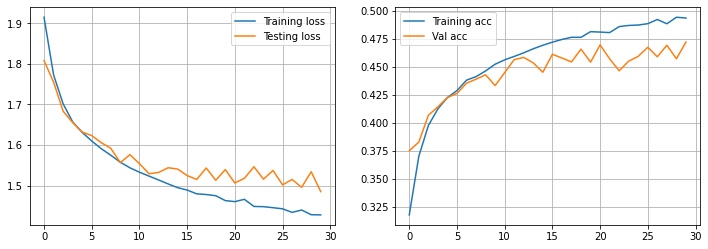

In [11]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Val acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [12]:
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 1.484925389289856
Test accuracy: 0.47200000286102295


## Hyperparameter search using sklearn

In [14]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [128]
epochs = [30]
n_neurons = [128, 256]
param_grid = dict(batch_size=batch_size, 
                  epochs=epochs, 
                  n_neurons=n_neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 